In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *

In [3]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv')]

In [4]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [5]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

In [0]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

In [0]:
data_lm.save()


In [0]:
data = load_data(path)


TOKENIZATION


In [11]:
data = TextClasDataBunch.from_csv(path, 'texts.csv')
data.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , steaming bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj xxunk . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first stealth games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - rounded gaming experience in general . xxmaj with graphics",positive
"xxbos i really wanted to love this show . i truly , honestly did . \n \n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance",negative


NUMERICALIZATION


In [12]:
data.vocab.itos[:10]


['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 '.']

In [13]:
data.train_ds[0][0]


Text xxbos i was blown away by the re - imagined xxmaj battlestar xxmaj xxunk , a show that always kept me guessing and brought me to tears on more than one occasion . a xxunk sci - fi fan , i like to think i can pick out the good stuff from the xxup xxunk , and this was good stuff . 
 
  xxmaj as such , when i first heard about the prospect of a xxunk series some months ago i got a sick feeling in my gut . i was afraid that the formula that made xxmaj battlestar so successful would be xxunk in xxmaj caprica , which would n't work at all . xxup bsg 's story , of a mournful ragged band of survivors , trapped aboard xxunk star ships and guided by prophetic vision and a sequence of pseudo - xxunk , was perfectly complimented by extraordinary music and a better cast of actors . 
 
  xxmaj caprica feels different . xxmaj where xxup bsg takes place after the fall of a great civilization , xxmaj caprica portrays that civilization in it 's cold and decadent heyday . xxmaj the overall xxunk i g

In [14]:
data.train_ds[0][0].data[:10]


array([   2,   18,   23, 2167,  253,   48,    8,  648,   24, 3189])

WITH THE DATA BLOCK API

In [0]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

LANGUAGE MODEL


In [0]:
bs=48


In [17]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/test')]

In [18]:
(path/'train').ls()


[PosixPath('/root/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/neg'),
 PosixPath('/root/.fastai/data/imdb/train/pos'),
 PosixPath('/root/.fastai/data/imdb/train/unsupBow.feat')]

In [0]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [0]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)


In [21]:
data_lm.show_batch()


idx,text
0,"of the story could have been good , with a better effort to depict the inner feelings of a man who had to live with alcohol and violence since his youth . \n \n xxmaj sadly , the general idea seems to be more like "" i 'm the way i am because that 's the way i am "" . xxmaj and the laughingly bad attempt at giving"
1,"into an exalted intellectual social science . xxmaj giving idiotic movies like "" xxmaj birds "" this much thought , hence this much credit , probably has its fat creator laughing in his grave . xxmaj the raw truth is that the vast majority of movies have zero intellectual value , and the few ones that do have some intelligence do n't require a shrink - turned - philosopher to"
2,"scooby xxmaj doo movies and the old episodes . i love the 1990s movies , and recently we were treated to one of the better direct to xxup dvd xxmaj scooby xxmaj doo outings of this decade , xxmaj scooby xxmaj doo and the xxmaj goblin xxmaj king , which i was n't expecting to be as good as it was . xxmaj anyway , back to xxmaj get a"
3,"the coloring . xxmaj the flies were an unusual blue - gray that was kind of distracting to me . \n \n xxmaj the performances from the cast was not bad , but it was n't good either . xxmaj there were many times i focused more on my computer than the story . xxmaj the writing was certainly written for a younger audience , with comedic moments that"
4,"watching . xxmaj pegg , though , plays himself , xxmaj kirsten xxmaj dunst seems to just go though the motions , creating no on screen chemistry , and xxmaj megan xxmaj fox is n't stretched at all . xxmaj the one huge plus is xxmaj miriam xxmaj margolyes , as xxmaj pegg 's xxmaj new xxmaj york landlady - now if she had been on screen longer xxrep 5"


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)


In [23]:
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


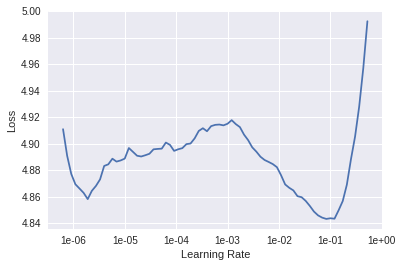

In [24]:
learn.recorder.plot(skip_end=15)


In [25]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,4.207960,4.057991,0.293445,1:29:40


In [0]:
  learn.save('fit_head')

In [0]:
learn.load('fit_head');

In [0]:
learn.unfreeze()

In [29]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.930897,3.883732,0.310954,1:39:54


KeyboardInterrupt: ignored

In [0]:
learn.save('fine_tuned')


In [31]:
learn.load('fine_tuned');


ValueError: ignored

In [0]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [33]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))


I liked this movie because it was so direct . It should have been more of a comedy . The characters are good , and i have n't seen the movie so many times since i was a kid and i ca n't
I liked this movie because i am sure the movie is true . i liked it so much , i could do it with David Warner . i think you can use Ed Wood , John Paxton and


In [0]:
learn.save_encoder('fine_tuned_enc')


CLASSIFIER

In [0]:
path = untar_data(URLs.IMDB)


In [0]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [0]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)


In [38]:
data_clas.show_batch()


text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj warning : xxmaj does contain spoilers . \n \n xxmaj open xxmaj your xxmaj eyes \n \n xxmaj if you have not seen this film and plan on doing so , just stop reading here and take my word for it . xxmaj you have to see this film . i have seen it four times so far and i still have n't made up my",pos
"xxbos xxmaj jim xxmaj carrey is back to much the same role that he played in xxmaj the xxmaj mask , a timid guy who is trying to get ahead in the world but who seems to be plagued with bad luck . xxmaj even when he tries to help a homeless guy from being harassed by a bunch of hoodlums ( and of course they have to be xxmaj",pos
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",pos
"xxbos xxmaj in xxup nyc , seaman xxmaj michael o'hara ( xxmaj orson xxmaj welles ) rescues xxmaj elsa xxmaj bannister ( xxmaj rita xxmaj hayworth ) from a mugging & rape as she takes a horse & carriage through xxmaj central xxmaj park -and lives to regret it . xxmaj xxunk - haired xxmaj hayworth 's a platinum blonde in this one ; as dazzling as fresh - fallen",pos


In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [40]:
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


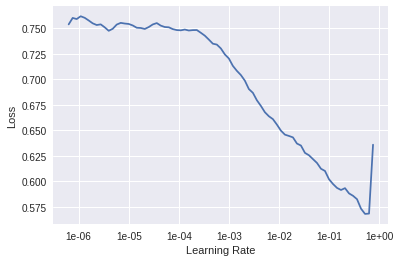

In [41]:
learn.recorder.plot()


In [42]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,0.397760,0.287406,0.879080,12:13


In [0]:
learn.save('first')


In [0]:
learn.load('first');


In [45]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.322130,0.225888,0.909160,12:59


In [0]:
learn.save('second')


In [0]:
learn.save('second');

In [48]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.274505,0.189710,0.925520,18:53


In [0]:
learn.save('third')


In [0]:
learn.load('third');


In [53]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

RuntimeError: ignored

In [54]:
learn.predict("I really loved that movie, it was awesome!")


(Category pos, tensor(1), tensor([1.5318e-04, 9.9985e-01]))